In [9]:
import os
from os import path

from igraph import *

from PIL import Image, ImageDraw, ImageFont

import pandas as pd
import json

from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import AlignIO

import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [2]:
# Various datasets to visualize

option = 14
time0 = time1 = ''

if option == 13:    
    title = "SPIKE TEST"
    base_folder = "./simulations/spike2"
    sim_id = 141
    pathogen_id = 16
    sim_tz = "US/Eastern"
    time0 = 'Jun 11 2023 10:10AM'
    time1 = 'Jun 11 2023 11:10AM'
    time_step_min = 1
    use_new_id_schema = True
if option == 14:
    title = "WKU"
    base_folder = "./simulations/wku23"
    sim_id = 165
    pathogen_id = 20
    sim_tz = "Asia/Shanghai"
    time0 = 'Nov 20 2023 9:00AM'
    time1 = 'Dec 4 2023 12:00PM'
    time_step_min = 30
    use_new_id_schema = True

In [3]:
# Configuration

data_folder = path.join(base_folder, "data")
output_root = path.join(base_folder, "output")
output_folder = path.join(output_root, "phylo")
if not path.exists(output_folder):
    os.makedirs(output_folder)

style = {}
style["bbox"] = (1200, 800)
style["margin"] = 15
style["vertex_size"] = 7
style["vertex_frame_width"] = 0
style["edge_arrow_size"] = 0.6
style["edge_arrow_width"] = 0.6
style["edge_curved"] = False

label_font = ImageFont.truetype("Roboto-Regular.ttf", size=24)

In [4]:
# Load the data

all_users = pd.read_csv(path.join(data_folder, "participants.csv"))
all_sequences = pd.read_csv(path.join(data_folder, "sequences.csv"))
all_mutations = pd.read_csv(path.join(data_folder, "mutations.csv"))

users = all_users[all_users["sim_id"] == sim_id]
ref_seq = list(all_sequences[all_sequences["pathogen_id"] == pathogen_id]["sequence"].values[0])
mutations = all_mutations[all_mutations["sim_id"] == sim_id]
mutations = mutations.assign(sequence='')
mutations.sort_values(by=['id'], inplace=True)

#print(''.join(ref_seq))
#print(mutations)

In [5]:
# Save all the recorded sequences

def apply_delta(seq, delta):
    for k in delta.keys():
        pos = int(k)
        nt0, nt1 = delta[k].split('-')
        seq[pos] = nt1

def add_sequence(id, pid, seq, lines):
    if id == 0:
        lines += [">seq" + str(pathogen_id if pid == 0 else pid)]
    else:
        lines += [">seq" + str(pathogen_id if pid == 0 else pid) + "-" + str(id)]
    lines += [''.join(seq)]

def get_prev_seq(p_mut_id, transmissions, fasta_lines):
    if p_mut_id == 0:
        return ref_seq.copy()
    else:
        prev_mutation = mutations[mutations["id"] == p_mut_id]
        prev_seq = list(prev_mutation["sequence"].values[0])
        if prev_seq:
            return prev_seq
        else:
            if prev_mutation["id"].values[0] != p_mut_id:
                print("Error, inconsistent mutation ID for", p_mut_id)
                return []
            pp_mut_id = prev_mutation["prev_mutation_id"].values[0]
            prev_seq = get_prev_seq(pp_mut_id, transmissions, fasta_lines)
            if not prev_seq: return []
            apply_delta(prev_seq, json.loads(prev_mutation["delta"].values[0]))
            prev_mutation["sequence"].values[0] = prev_seq
            add_seq = True
            if pathogen_id < pp_mut_id:
                t = (pp_mut_id - pathogen_id - 1, p_mut_id - pathogen_id - 1)
                if not t in transmissions:
                    transmissions += [t]
                else:
                    print("Warning: duplicated transmission", str(pp_mut_id) + "-" + str(p_mut_id))
                    add_seq = False
            if add_seq: add_sequence(p_mut_id, pp_mut_id, prev_seq, fasta_lines)
            return prev_seq.copy()

transmissions = []
fasta_lines = []

for idx in mutations.index:
    mut_id = mutations["id"][idx]
    p_mut_id = mutations["prev_mutation_id"][idx]
    seq = mutations["sequence"][idx]
    if seq: continue
    prev_seq = get_prev_seq(p_mut_id, transmissions, fasta_lines)
    if not prev_seq: 
        print("Error, cannot resolve sequence for mutation", p_mut_id)
        continue
    apply_delta(prev_seq, json.loads(mutations["delta"][idx]))
    mutations.at[idx, "sequence"] = prev_seq
    add_seq = True
    if pathogen_id < p_mut_id:
        t = (p_mut_id - pathogen_id - 1, mut_id - pathogen_id - 1)
        if not t in transmissions:
            transmissions += [t]
        else:
            print("Warning: duplicated transmission", str(p_mut_id) + "-" + str(mut_id))
            add_seq = False
    if add_seq: add_sequence(mut_id, p_mut_id, prev_seq, fasta_lines)

print("Saving FASTA file")
fasta_fn = path.join(output_folder, "sequences.fasta")
with open(fasta_fn, 'w') as f:
    for line in fasta_lines:
        f.write(line + '\n')

print("Saving MSA file")
# All sequences from the sim align perfectly since they only differ in point mutations
# from one another.
phy_fn = path.join(output_folder, "msa.phy")
with open(phy_fn, 'w') as f:
    f.write(str(int(len(fasta_lines)/2)) + " " + str(len(ref_seq)) + '\n')
    for i in range(1, len(fasta_lines), 2):
        name = fasta_lines[i - 1]
        seq = fasta_lines[i]
        f.write(name[4:].ljust(10) + seq + '\n')

Saving FASTA file
Saving MSA file


In [6]:
# Create network of transmissions from sequence data

nvert = len(mutations)
labels = list(mutations["id"].astype(str))
g = Graph(directed=True)
g.add_vertices(nvert)
g.add_edges(transmissions)

style["layout"] = g.layout_fruchterman_reingold()
style["vertex_label"] = labels
style["vertex_label_size"] = 10
style["vertex_label_dist"] = 1.3

print("Saving network image")
img_fn = path.join(output_folder, "transmissions.pdf")
p = plot(g, img_fn, **style)

Saving network image


In [7]:
# Generate phylogenetic tree from the sequences
# (could also do online using the Fasta file in https://www.ebi.ac.uk/Tools/msa/clustalo/)

print("Generating phylogenetic tree")

aln = AlignIO.read(phy_fn, 'phylip')

calculator = DistanceCalculator('identity')
dm = calculator.get_distance(aln)

constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)

tree_fn = path.join(output_folder, "tree.dnd")
Phylo.write(tree, tree_fn, "newick")

Generating phylogenetic tree


1

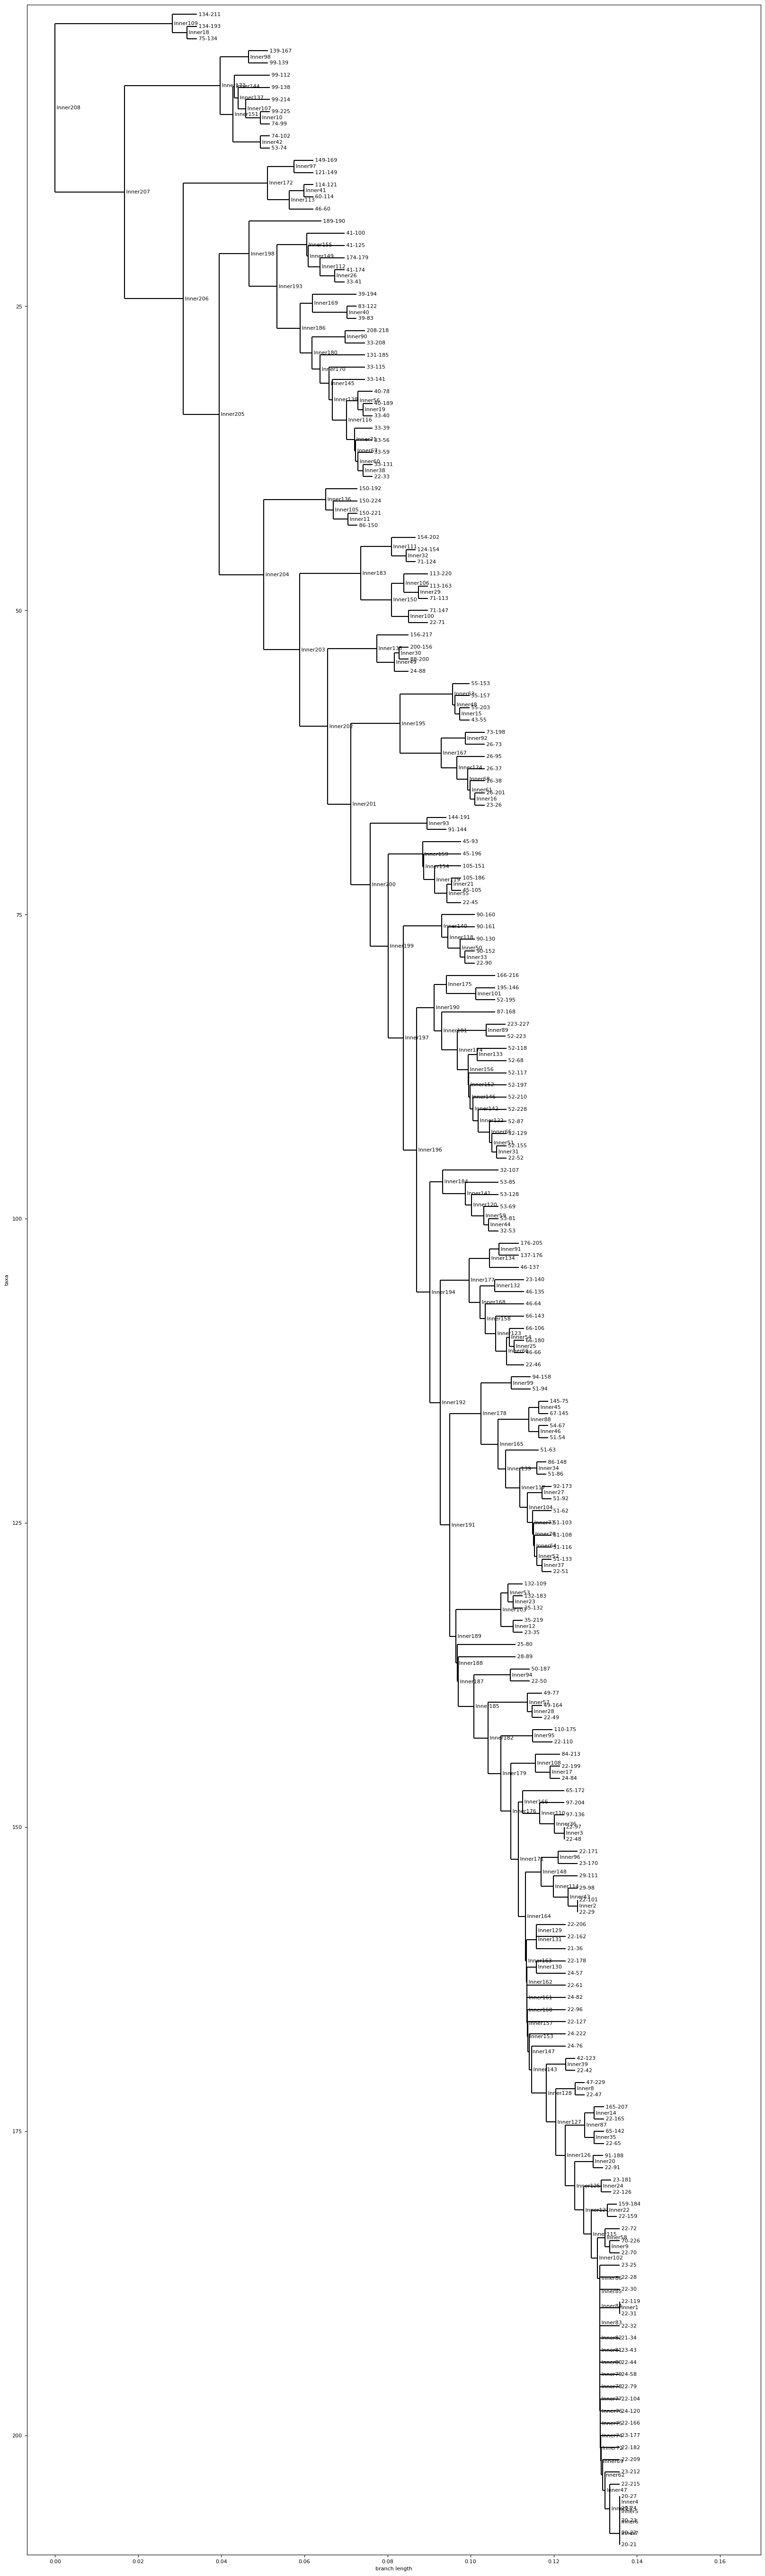

Saving tree image with linear layout


NameError: name 'networkx' is not defined

In [8]:
img_linear_fn = path.join(output_folder, "tree-linear.pdf")
img_radial_fn = path.join(output_folder, "tree-radial.pdf")

matplotlib.rc('font', size=8)

fig, ax = plt.subplots(figsize=(20, 70), dpi=100)
Phylo.draw(tree, axes=ax, do_show=False)
plt.show()

print("Saving tree image with linear layout")
Phylo.draw(tree, axes=ax, do_show=False)
fig.tight_layout()
fig.savefig(img_linear_fn, dpi=100)

net = Phylo.to_networkx(tree)
pos = nx.nx_agraph.graphviz_layout(net, prog="twopi", args="")
fig = plt.figure(figsize=(10, 8))
nx.draw(net, pos, node_size=20, arrowsize=5, alpha=0.5, node_color="blue", with_labels=False)
plt.axis("equal")
plt.show()

print("Saving tree image with radial layout")
fig.savefig(img_radial_fn, dpi=100)